# Quarter 2: Project

The main deliverable for the second quarter of the computational economics and finance class is a project to showcase what you have learned. The goal of this project is for you (potentially in a small group) to produce a piece of work (in the form of a Jupyter notebook) that you would be able to use to showcase the skills that you have learned in this class to potential employers or academic advisors.

The relatively loose structure in self-directed projects like this makes them a bit more challenging than other things that you will do in school, but we think it also makes them more interesting. They give you a chance to indulge your curiosity and show off your creativity.

We have broken the project into three components to keep you on track. Each of these components should be turned in as its own Jupyter notebook. The first two steps are graded almost entirely on whether you do them or not. You must complete the first two steps on your own. When you actually begin working on the final project, you may work in groups of two to four, but you may also work alone if you’d  prefer.

## Project Ideas

**(15% of project grade)**

Form a team of between one and four students (no more) and choose a project. This project could come from the ideas that you submitted or some other idea if you get a sudden flash of inspiration. Flesh out the project in detail -- When we say “flesh it out in detail”, we mean properly load the data into the notebook, describe in words what you want to explore, and create a couple draft quality visualizations (don’t worry about making them pretty) that whets a reader’s appetite.

Please include the names of all group members in the below:

* Jian Zhou

**Please note that each person should make a copy of the notebook and turn it in!**


## Proposal:

Include your project proposal, data, and graphs in the cells below

### Project Proposal

The stochastic volatility model is the canonical method to model asset return volatility. Nonetheless, the stochastic models usually don’t have closed-form analytic solution and computational-heavy to calibrate due to model complexity. Monte Carlo Markov Chain has grown to be one of the most effective and popular tools in analyzing the stochastic volatility model. Priors and data are fed into the model, and posteriors are the calibrated model parameters of interest. 

We have noticed that the VIX index has been rather volatile since the outbreak of COVID-19 and peaked in March 2019. The traditional stochastic volatility fails to capture the spike due to the inactivity to model exogenous shock.  

We proposed to extend the canonical stochastic volatility to incorporate covid-19 data under a Monte Carlo Markov Chain framework. The following formulas set the extended stochastic volatility model.

We plan to sample and calibrate the extended stochastic volatility model. Furthermore, we will conduct a model comparison to check whether the comprehensive model supersedes the canonical model. 

### Data

In [259]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
%matplotlib inline

In [208]:
finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
finance_data = finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX'}, axis=1)
finance_data

[*********************100%***********************]  2 of 2 completed


,SP500,VIX
Date,,
2017-01-03,2257.830078,12.850000
2017-01-04,2270.750000,11.850000
2017-01-05,2269.000000,11.670000
2017-01-06,2276.979980,11.320000
2017-01-09,2268.899902,11.560000
...,...,...
2021-01-04,3700.649902,26.969999
2021-01-05,3726.860107,25.340000
2021-01-06,3748.139893,25.070000


In [126]:
_covid_19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
           error_bad_lines=False)

In [197]:
covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19['global'] = covid_19.apply('sum', axis=1)
covid_19_data = covid_19[['US', 'global']]
covid_19_data.index = covid_19_data.reset_index()['index'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%y'))
covid_19_data

Country/Region,US,global
index,,
2020-01-22,1,555
2020-01-23,1,654
2020-01-24,2,941
2020-01-25,2,1434
2020-01-26,5,2118
...,...,...
2021-01-06,21354750,87241950
2021-01-07,21635491,88104210
2021-01-08,21928012,88925739


In [266]:
data = finance_data.merge(covid_19_data, left_index=True, right_index=True)
data['cases_growth_US'] = np.log(data['US']).diff().rolling(14, win_type='gaussian').mean(std=3)

### Graphs

VIX peaks at March, 2020, as the covid-19 panics the street. 

Furthermore, we notice that VIX sicne covid-19 has been stably higher than before, implying some systematic change


<AxesSubplot:xlabel='Date'>

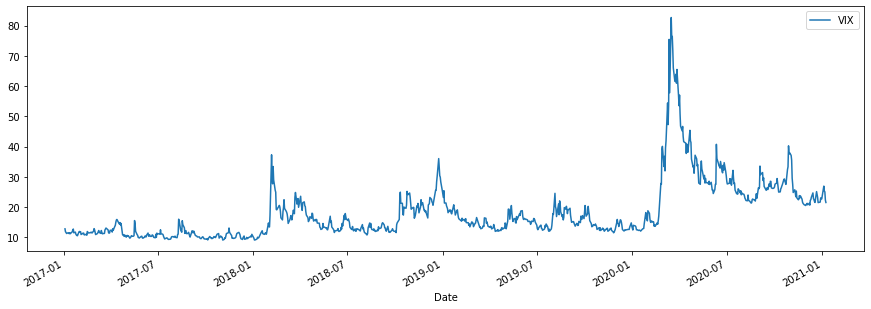

In [273]:
finance_data.plot(y=['VIX'], use_index=True, figsize=(15,5))

The log-difference of the confirmed cases of covid-19 (2-week gaussian smoothed) spiked in March, 2020.

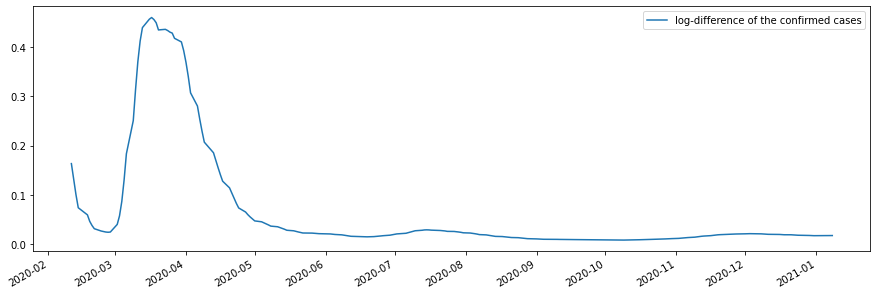

In [283]:
data.plot(y=['cases_growth_US'], use_index=True, label=["log-difference of the confirmed cases"], figsize=(15,5))
plt.legend()

There is a salient overlap in March, 2020. If we plot VIX and cases together,  

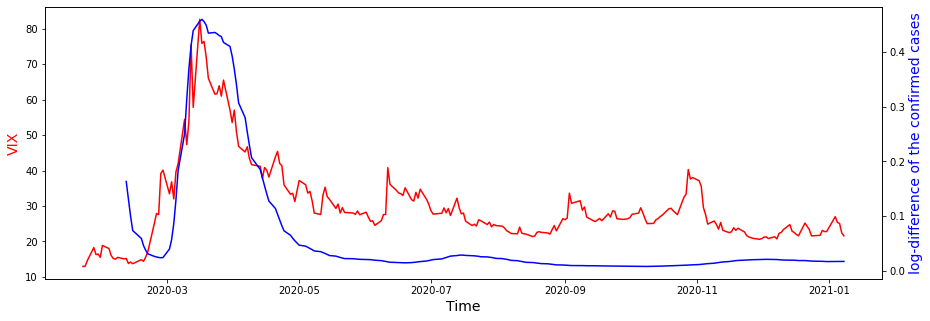

In [284]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time",fontsize=14)
# set y-axis label
ax.set_ylabel("VIX",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'],color="blue")
ax2.set_ylabel("log-difference of the confirmed cases",color="blue",fontsize=14)
plt.show()

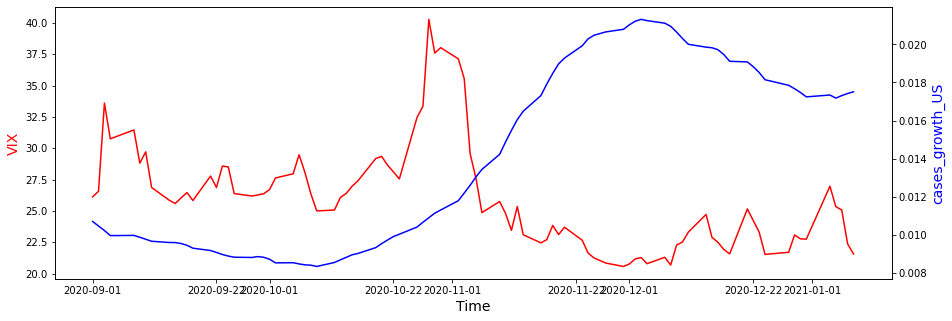

In [270]:
sliced_data = data.loc['2020-09':, :]
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(sliced_data.index, sliced_data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time",fontsize=14)
# set y-axis label
ax.set_ylabel("VIX",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(sliced_data.index, sliced_data['cases_growth_US'],color="blue")
ax2.set_ylabel("cases_growth_US",color="blue",fontsize=14)
plt.show()

In [2]:
# todo

# covid-19 versus sp 500
# covid-19 versus vix
# covid-19 log number versus vix